#### Code to extract test data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/Documents/kaggle_siim_covid/src


## Imports

In [3]:
import os
import cv2
import glob
import gdcm
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.notebook import tqdm

In [4]:
from params import *
from data.extraction import *

### Params

In [5]:
if not os.path.exists(DCM_PATH):
    DCM_PATH = DATA_PATH

In [6]:
SIZE = 512
DATABASE = "test"
SAVE_DIR = DATA_PATH + f"{DATABASE}_{SIZE}/"

if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

In [7]:
sub = pd.read_csv(DATA_PATH + "sample_submission.csv")

In [8]:
def prepare_df_test(sub, root):
    stacks = glob.glob(root + "/*/*/*.dcm")
    
    img_ids = []
    study_ids = []

    for stack in stacks:
        study, _, img = stack.split('/')[-3:]
        img_ids.append(img[:-4] + "_image")
        study_ids.append(study)
    
    df = pd.DataFrame({"id": img_ids, "StudyInstanceUID": study_ids})
    
    sub = sub[sub['PredictionString'].apply(lambda x: "none" in x)].reset_index(drop=True)
    
    return sub.merge(df)

In [9]:
df = prepare_df_test(sub, os.path.join(DCM_PATH, DATABASE))

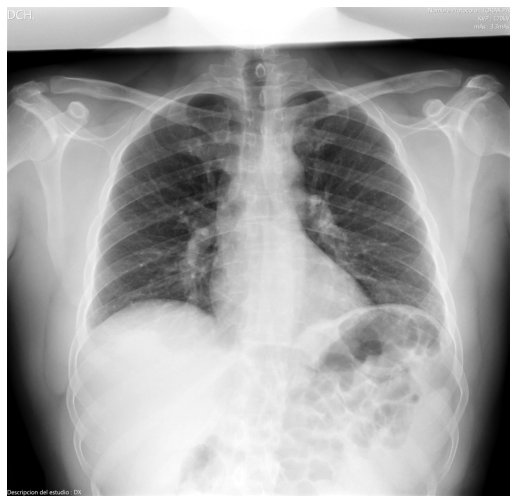

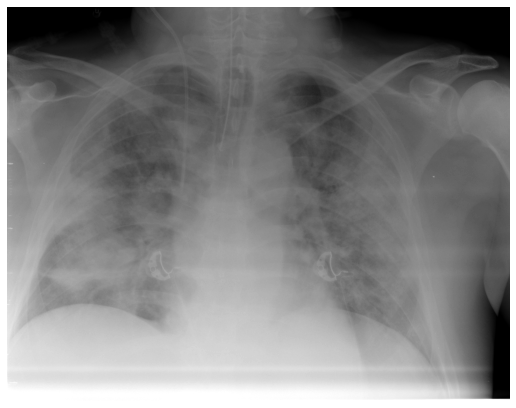

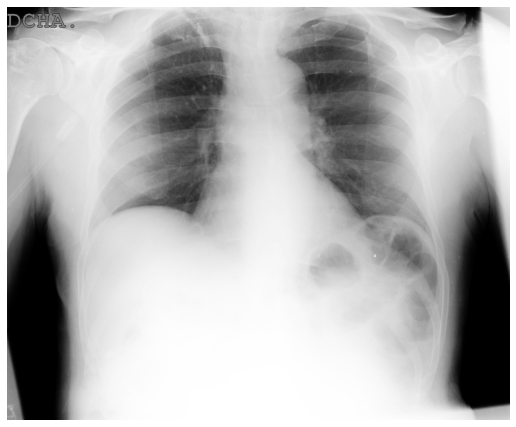

In [10]:
infos = []
for i in tqdm(range(len(df))):
    study = df['StudyInstanceUID'][i]
    image = df['id'][i].split('_')[0]

    study_path = os.path.join(DCM_PATH, DATABASE, study)
    series = os.listdir(study_path)
    
    found = False
    for s in series:
        img_path = os.path.join(study_path, s, image + ".dcm")
        if os.path.exists(img_path):
            found = True
            break
            
    if not found:
        print(f'Image {i} not found')
        continue
    
    img, meta = read_xray(img_path)
    shape = img.shape

    img, window = auto_windowing(img)

    img, crop_starts = remove_padding(img)
    shape_crop = img.shape

    if not (i % 500):
        plt.figure(figsize=(9, 9))
        plt.imshow(img, cmap="gray")
        plt.axis(False)
        plt.show()
        
    img = cv2.resize(img, (SIZE, SIZE), interpolation=cv2.INTER_LINEAR)
    
    save_name = f"{study}_{image}.png"
    cv2.imwrite(SAVE_DIR + save_name, img)

    info_dic = {
        "study_id": [study],
        "series_id": [s],
        "image_id": [image],
        "save_name": [save_name],
        "shape": [shape],
        "shape_crop": [shape_crop],
        "window": [window],
        "crop_starts": [crop_starts],
        "photometric_interpreation": [meta.PhotometricInterpretation],
        "series_number": [meta.SeriesNumber],
        "instance_number": [meta.InstanceNumber],
    }
    infos.append(pd.DataFrame.from_dict(info_dic))

#     break

infos = pd.concat(infos).reset_index(drop=True)
infos.to_csv(DATA_PATH + f'df_{DATABASE}_{SIZE}.csv', index=False)

In [11]:
infos.head()

,study_id,series_id,image_id,save_name,shape,shape_crop,window,crop_starts,photometric_interpreation,series_number,instance_number
0,795051254905,2d4fb41c0707,557a70442928,795051254905_557a70442928.png,"(3320, 3408)","(3320, 3408)","(49.0, 3481.0)","(0, 0)",MONOCHROME2,1,1
1,0d476d070d71,360c62464c4c,36141cda67ad,0d476d070d71_36141cda67ad.png,"(3480, 4240)","(3480, 4240)","(112.0, 3579.0)","(0, 0)",MONOCHROME2,1,1
2,4996bf5117c7,0bd4b304da3a,2413a23a5477,4996bf5117c7_2413a23a5477.png,"(2320, 2832)","(2320, 2832)","(33.0, 234.0)","(0, 0)",MONOCHROME2,1,1
3,8b273337a684,1f0bb9f0aa75,c263b1e9aa64,8b273337a684_c263b1e9aa64.png,"(2801, 2802)","(2801, 2801)","(129.0, 2829.0)","(0, 0)",MONOCHROME2,1,1
4,aafc8126d5a1,43442e48d3cb,4fe0444d7fc5,aafc8126d5a1_4fe0444d7fc5.png,"(2392, 3014)","(2383, 3008)","(114.0, 2563.0)","(7, 6)",MONOCHROME2,1,1
